# Data

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


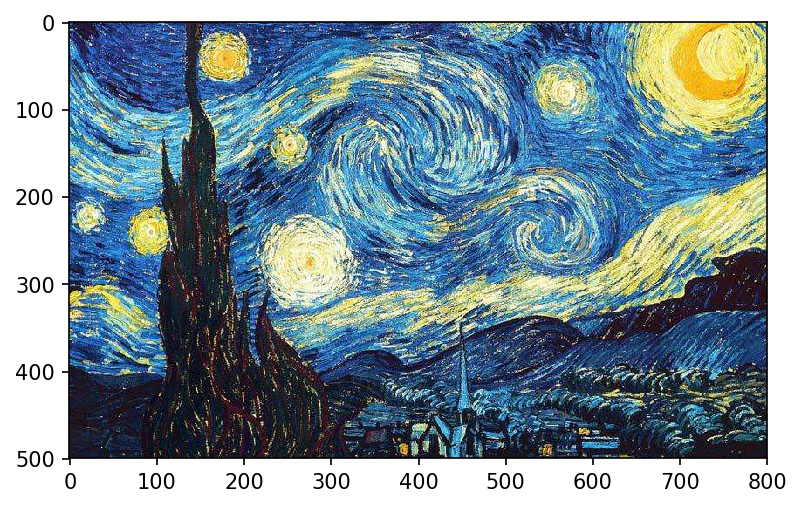

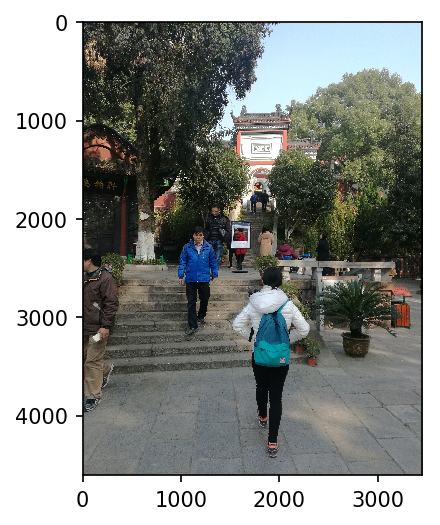

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt

from mxnet import image

# style_img = image.imread('../img/autumn_oak.jpg')
# content_img = image.imread('../img/pine-tree.jpg')

style_img = image.imread('../img/fg_style1.jpg')
content_img = image.imread('../img/fjqcg1.jpg')

plt.imshow(style_img.asnumpy())
plt.show()
plt.imshow(content_img.asnumpy())
plt.show()

In [2]:
from mxnet import ndarray as nd

rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis = 0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1) 

# Model

In [3]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.vgg19(pretrained = True)
pretrained_net

VGG(
  (features): HybridSequential(
    (0): Conv2D(64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Activation(relu)
    (16): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): Activation(relu)
    (18): Max

In [4]:
# style_layers = [0, 5, 10, 19, 28]
style_layers = [0, 5, 10, 19]
content_layers = [25]

In [5]:
max(content_layers + style_layers) 

25

In [6]:
from mxnet.gluon import nn

def get_net(pretrained_net, content_layers, style_layers):
    net = nn.Sequential()
    for i in range(max(content_layers + style_layers) + 1):
        net.add(pretrained_net.features[i])
    return net

net = get_net(pretrained_net, content_layers, style_layers)

In [7]:
print(len(net), net[25])

26 Conv2D(512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [8]:
def extract_features(x, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):  # from 0 layer to len(net) layer
        x = net[i](x)    # recursion
        if i in style_layers:
            styles.append(x)
        if i in content_layers:
            contents.append(x)
    return contents, styles

# Loss Function

In [9]:
def content_loss(yhat, y):
    return (yhat - y).square().mean()

In [10]:
def gram(x):
    c = x.shape[1]
    n = x.size / x.shape[1]
    y = x.reshape((c, int(n)))
    return nd.dot(y, y.T) / n

gram(nd.ones((1, 3, 4, 4)))


[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
<NDArray 3x3 @cpu(0)>

In [11]:
a = nd.ones((2, 3, 4, 4))
n = a.size / a.shape[1]
y = a.reshape((a.shape[1], int(n)))
print('a:', a, '\n n:', n, '\n y:', y, '\n y*y.T:', nd.dot(y, y.T))

a: 
[[[[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]

  [[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]

  [[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]

  [[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]

  [[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
<NDArray 2x3x4x4 @cpu(0)> 
 n: 32.0 
 y: 
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
<NDArray 3x32 @cpu(0)> 
 y*y.T: 
[[

In [12]:
def style_loss(yhat, gram_y):
    return (gram(yhat) - gram_y).square().mean()

In [13]:
def tv_loss(yhat):
    return 0.5 * ((yhat[:, :, 1:, :] - yhat[:, :, :-1, :]).abs().mean() + 
                  (yhat[:, :, :, 1:] - yhat[:, :, :, :-1]).abs().mean())

In [14]:
channels = [net[l].weight.shape[0] for l in style_layers] # output channels (64 128 256 512)
style_weights = [1e4 / n ** 2 for n in channels] # bigger weight in layer close to input
content_weights = [1] # make content_weights as benchmark
tv_weight = 10

In [15]:
def sum_loss(loss, preds, truths, weights):
    return nd.add_n(*[w * loss(yhat, y) for w, yhat, y in zip(
        weights, preds, truths)])

# Train

In [16]:
def get_contents(image_shape):
    content_x = preprocess(content_img, image_shape).copyto(ctx)
    content_y, _ = extract_features(content_x, content_layers, style_layers)
    return content_x, content_y

def get_styles(image_shape):
    style_x = preprocess(style_img, image_shape).copyto(ctx)
    _, style_y = extract_features(style_x, content_layers, style_layers)
    style_y = [gram(y) for y in style_y]  # save covariance(style_y)
    return style_x, style_y

In [17]:
from time import time
from mxnet import autograd as ag

def train(x, max_epochs, lr, lr_decay_epoch = 200):
    tic = time()
    for i in range(max_epochs):
        with ag.record():
            content_py, style_py = extract_features(
                x, content_layers, style_layers)
            content_L = sum_loss(
                content_loss, content_py, content_y, content_weights)
            style_L = sum_loss(
                style_loss, style_py, style_y, style_weights)
            tv_L = tv_weight * tv_loss(x)
            loss = style_L + content_L + tv_L
            
        loss.backward()
        x.grad[:] /= x.grad.abs().mean() + 1e-8  # norm grad to make it not sensitive to params
        x[:] -= lr * x.grad
        # add sync to avoid large mem usage
        nd.waitall()
        
        if i and i % 20 == 0:  # i > 0 && i % 20 = 0
            print('epoch %3d, content %.2f, style %.2f, '
                 'TV %.2f, time %.1f sec' % (
                     i, content_L.asscalar(), style_L.asscalar(), 
                     tv_L.asscalar(), time() - tic))
            tic = time()
            
        if i and i % lr_decay_epoch == 0:
            lr *= 0.1
            print('change lr to ', lr)
    
    plt.imshow(postprocess(x).asnumpy())
    plt.show()
    return x

epoch  20, content 28.72, style 90.92, TV 4.35, time 0.7 sec
epoch  40, content 28.81, style 233.83, TV 4.67, time 0.6 sec
epoch  60, content 26.09, style 253.61, TV 4.75, time 0.6 sec
epoch  80, content 26.66, style 314.90, TV 4.75, time 0.6 sec
epoch 100, content 25.46, style 239.75, TV 4.96, time 0.6 sec
epoch 120, content 23.85, style 228.85, TV 5.04, time 0.6 sec
epoch 140, content 24.39, style 340.68, TV 4.90, time 0.6 sec
epoch 160, content 24.17, style 197.58, TV 5.14, time 0.6 sec
epoch 180, content 23.48, style 286.27, TV 5.07, time 0.6 sec
epoch 200, content 23.23, style 227.60, TV 5.25, time 0.6 sec
change lr to  0.010000000000000002
epoch 220, content 12.85, style 10.55, TV 5.00, time 0.6 sec
epoch 240, content 10.48, style 9.32, TV 4.95, time 0.6 sec
epoch 260, content 10.15, style 7.69, TV 4.90, time 0.6 sec
epoch 280, content 8.99, style 6.86, TV 4.84, time 0.6 sec
epoch 300, content 8.58, style 6.41, TV 4.79, time 0.6 sec
epoch 320, content 8.24, style 6.15, TV 4.76, t

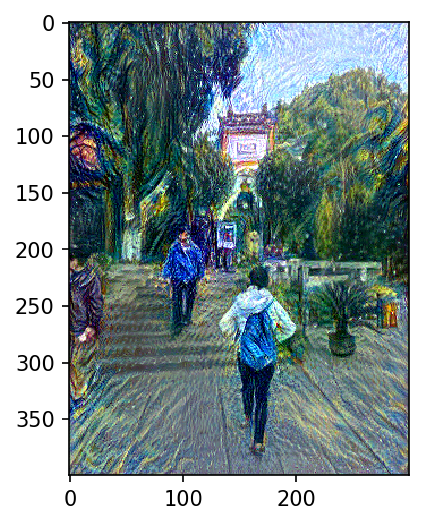

In [18]:
import sys
sys.path.append('..')
import utils

# image_shape = (300, 200)
image_shape = (300, 400)

ctx = utils.try_gpu()
net.collect_params().reset_ctx(ctx)

content_x, content_y = get_contents(image_shape)
style_x, style_y = get_styles(image_shape)

x = content_x.copyto(ctx)
# x = nd.zeros((content_x.shape), ctx = ctx)
x.attach_grad()

y = train(x, 500, 0.1)

epoch  20, content 20.08, style 127.48, TV 2.62, time 10.9 sec
epoch  40, content 18.27, style 100.62, TV 2.95, time 10.1 sec
epoch  60, content 17.63, style 90.91, TV 3.17, time 10.1 sec
epoch  80, content 16.95, style 86.15, TV 3.33, time 10.1 sec
epoch 100, content 16.53, style 85.17, TV 3.48, time 10.1 sec
change lr to  0.010000000000000002
epoch 120, content 10.35, style 9.53, TV 3.06, time 10.1 sec
epoch 140, content 8.70, style 6.03, TV 2.92, time 10.1 sec
epoch 160, content 7.39, style 4.31, TV 2.83, time 10.6 sec
epoch 180, content 6.70, style 3.30, TV 2.74, time 10.1 sec
epoch 200, content 6.55, style 5.15, TV 2.66, time 10.1 sec
change lr to  0.0010000000000000002
epoch 220, content 5.67, style 2.02, TV 2.61, time 10.1 sec
epoch 240, content 5.42, style 1.85, TV 2.57, time 10.1 sec
epoch 260, content 5.24, style 1.73, TV 2.54, time 10.1 sec
epoch 280, content 5.10, style 1.63, TV 2.51, time 10.1 sec


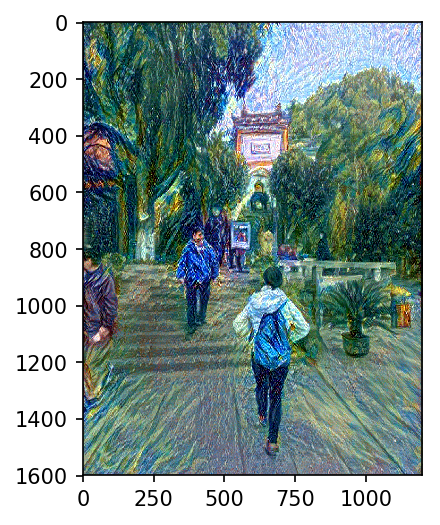

In [19]:
# image_shape = (1200, 800)
image_shape = (1200, 1600)

content_x, content_y = get_contents(image_shape)
style_x, style_y = get_styles(image_shape)

x = preprocess(postprocess(y) * 255, image_shape).copyto(ctx)
x.attach_grad()

z = train(x, 300, 0.1, 100)

In [20]:
plt.imsave('result.png', postprocess(z).asnumpy())